In [2]:
from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')

import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from IPython.display import clear_output
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tabulate import tabulate
from tensorflow.keras import layers

%matplotlib inline

Cartesian = lambda x,y: np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
AddZ = lambda x: np.concatenate((x, np.zeros((x.shape[0], x.shape[1], 1))), axis=2)

Mounted at /content/drive


### Useful functions:

In [3]:
def Freq(Data = None):
  YantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/YantData.mat')['YantData'].flatten()
  res = np.array([YantData[i].shape[0] for i in range(YantData.shape[0])])
  return res

def Cluster(Z,Y,plot = True):

    data = np.column_stack((Z, Y))
    centers = Cartesian(np.array([-25,-8,8,25]),np.array([-25,-8,8,25]))
    kmeans = KMeans(n_clusters=16, init=centers)
    kmeans.fit(data)

    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    if plot:
      plt.figure(figsize=(12, 7))
      plt.title(f"Num of antennas: {Z.shape[0]}")
      plt.scatter(data[:, 0], data[:, 1], c=labels, cmap='viridis')
      plt.scatter(centers[:, 0], centers[:, 1], marker='X',c='red', s=100, label='Centers')
      plt.grid()
      plt.show()

    return data, labels

def dist(Z,Y,i):
    Z,Y = np.squeeze(Z[i]), np.squeeze(Y[i])
    data, labels = Cluster(Z,Y, plot = False)

    dist_data = []

    for l in range(16):
      dist_data.append(np.mean(data[labels == l][:,0]))
      dist_data.append(np.std(data[labels == l][:,0]))
      dist_data.append(np.mean(data[labels == l][:,1]))
      dist_data.append(np.std(data[labels == l][:,1]))

    return np.array(dist_data)

def SmartPadding(Z,Y,i, flatten = True):
    Z,Y = np.squeeze(Z[i]), np.squeeze(Y[i])
    data, labels = Cluster(Z,Y, plot = False)

    pad_data = None

    for l in range(16):
        labeled_data = np.vstack((data[labels == l], np.zeros((64 - np.sum(labels == l), 2))))
        pad_data = np.vstack((pad_data, labeled_data)) if pad_data is not None else labeled_data

    if flatten:
      return pad_data.flatten()
    else:
      return pad_data

def NaivePadding(Z,Y,i):
    data = np.column_stack((np.squeeze(Z[i]), np.squeeze(Y[i])))
    zeros = np.zeros((1024-data.shape[0],2))
    return np.vstack((data,zeros)).flatten()

def NoPadding(Z,Y,i):
    data = np.column_stack((np.squeeze(Z[i]), np.squeeze(Y[i])))
    return data.flatten()

def CreateData(mask = None):
    YantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/YantData.mat')['YantData'].flatten()
    ZantData = scipy.io.loadmat('/content/drive/MyDrive/AntData/ZantData.mat')['ZantData'].flatten()

    cost = scipy.io.loadmat('/content/drive/MyDrive/AntData/cost.mat')['cost'].squeeze()

    freq = Freq(YantData)
    if mask:
      YantData,ZantData,cost = YantData[freq == mask],ZantData[freq == mask],cost[freq == mask]
      data_list = [NoPadding(ZantData, YantData, i) for i in tqdm(range(ZantData.shape[0]))]
    else:
      data_list = [SmartPadding(ZantData, YantData, i, flatten = False) for i in tqdm(range(ZantData.shape[0]))]

    del YantData
    del ZantData

    return AddZ(np.array(data_list)), cost

def result(preds, reals):
  N = preds.shape[0]

  res = {'MPE':0,  '< 1%':0, '< 5%':0, '< 10%':0, '< 15%':0, '< 25%':0, '< 50%':0}


  for pred, real in zip(preds, reals):
    percentage_error = np.abs((pred - real)/ real) * 100
    try:
      res['MPE'] += (percentage_error / N)[0]
    except:
      res['MPE'] += (percentage_error / N)
    for i in [1,5,10,15,25,50]:
      res[f"< {i}%"] += 100 / N if percentage_error <= i else 0

  return res

result_table = lambda train_result, test_result: print(tabulate([['Train']+list(train_result.values()), ['Test']+list(test_result.values())], headers=list(train_result.keys()), tablefmt='pipe'))


### Data Reading:

In [4]:
mask = None
Data, cost = CreateData(mask = mask)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(Data, cost, test_size=0.3, random_state=42)

del Data
del cost

100%|██████████| 103201/103201 [04:21<00:00, 394.68it/s]


In [22]:
X_train, X_test = np.transpose(X_train, axes=(0,2,1)), np.transpose(X_test, axes=(0,2,1))

Show the Data:

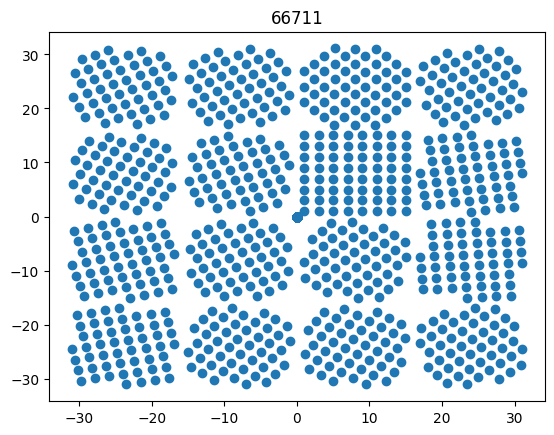

In [ ]:
for _ in range(10):
  clear_output(wait = True)
  i = np.random.randint(0,X_train.shape[0])
  plt.title(i)
  plt.scatter(X_train[i,:,0],X_train[i,:,1])
  plt.show()

### Data pre-processing (Optional)

In [ ]:
#x_mean = np.mean(X_train, axis = 0)
#x_std = np.std(X_train, axis = 0)

#y_mean = np.mean(y_train)
#y_std = np.std(y_train)

#X_train = (X_train - x_mean) / x_std
#X_test = (X_test - x_mean) / x_std

#y_train = (y_train - y_mean) / y_std
#y_test = (y_test - y_mean) / y_std

All possible masks: [ 800,  804,  808,  812,  816,  820,  824,  828,  832,  836,  840, 844,  848,  852,  856,  860,  864,  868,  872,  884,  888, 1024]

### PoinNet++

In [40]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return self.X[index], self.y[index]


class mlp(nn.Module):
    def __init__(self, in_size, out_size, k_size=1, batchnorm=True):
        """
        Creates a mlp layer as described in the paper.

        in_size: input size of the mlp
        out_size: output size of the mlp
        relu: apply relu
        batchnorm: apply norm
        """
        super(mlp, self).__init__()
        self.batchnorm = batchnorm
        self.conv = nn.Conv1d(in_size, out_size, k_size)
        self.bn = nn.BatchNorm1d(out_size)

    def forward(self, x):
        if self.batchnorm:
            return F.relu(self.bn(self.conv(x)))
        else:
            return self.conv(x)


class fc(nn.Module):
    def __init__(self, in_size, out_size, k_size=1, batchnorm=True, dropout=False, dropout_p=0.7):
        """
        Creates a fully connected layer as described in the paper.

        in_size: input size of the mlp
        out_size: output size of the mlp
        relu: apply relu
        batchnorm: apply norm
        """
        super(fc, self).__init__()
        self.batchnorm = batchnorm
        self.dropout = dropout

        self.fc = nn.Linear(in_size, out_size)
        self.bn = nn.BatchNorm1d(out_size)
        self.dp = nn.Dropout(p=dropout_p)

    def forward(self, x):
        if self.batchnorm and not self.dropout:
            return F.relu(self.bn(self.fc(x)))
        elif self.batchnorm and self.dropout:
            return F.relu(self.bn(self.dp(self.fc(x))))
        elif not self.batchnorm:
            return self.fc(x)


class TNet3(nn.Module):
    def __init__(self, device):
        super(TNet3, self).__init__()

        self.device = device

        self.mlp1 = mlp(3, 64)
        self.mlp2 = mlp(64, 128)
        self.mlp3 = mlp(128, 1024)

        self.fc1 = fc(1024, 512)
        self.fc2 = fc(512, 256, dropout=True)
        self.fc3 = fc(256, 9)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)

        x = torch.max(x, 2)[0]

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        #  For stability
        iden = torch.eye(3, 3).repeat(batch_size, 1, 1)
        if x.is_cuda:
            iden = iden.to(self.device)

        x = x.view(-1, 3, 3)
        x = x + iden

        return x


class TNet64(nn.Module):
    def __init__(self, device):
        super(TNet64, self).__init__()

        self.device = device

        self.mlp1 = mlp(64, 64)
        self.mlp2 = mlp(64, 128)
        self.mlp3 = mlp(128, 1024)

        self.fc1 = fc(1024, 512)
        self.fc2 = fc(512, 256, dropout=True)
        self.fc3 = fc(256, 64 * 64)

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.mlp1(x)
        x = self.mlp2(x)
        x = self.mlp3(x)

        x = torch.max(x, 2)[0]

        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)

        #  For stability
        iden = torch.eye(64, 64).repeat(batch_size, 1, 1)
        if x.is_cuda:
            iden = iden.to(self.device)

        x = x.view(-1, 64, 64)
        x = x + iden

        return x


class PointNetClass(nn.Module):
    def __init__(self, device, classes=1):
        """
        k: number of classes which a the input (shape) can be classified into
        """
        super(PointNetClass, self).__init__()
        self.device = device
        self.classes = classes

        self.TNet3 = TNet3(self.device)
        self.TNet64 = TNet64(self.device)

        self.mlp1 = mlp(3, 64)
        self.mlp2 = mlp(64, 64)
        self.mlp3 = mlp(64, 128)
        self.mlp4 = mlp(128, 1024)

        self.mlp5 = mlp(1024, 512)
        self.mlp6 = mlp(512, 256)
        self.mlp7 = mlp(256, self.classes, batchnorm=False)

    def forward(self, x):
        #  input transform:
        x_ = x.clone()
        T3 = self.TNet3(x_)
        x = torch.matmul(T3, x)

        #  mlp (64,64):
        x = self.mlp1(x)
        x = self.mlp2(x)

        # feature transform:
        x_ = x.clone()
        T64 = self.TNet64(x_)
        x = torch.matmul(T64, x)

        #  mlp (64,128,1024):
        x = self.mlp3(x)
        x = self.mlp4(x)

        x = torch.max(x, 2, keepdim=True)[0]

        x = self.mlp5(x)
        x = self.mlp6(x)
        x = self.mlp7(x)

        return x.squeeze()

train_dataset = MyDataset(X_train, y_train)
test_dataset = MyDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

del X_train, X_test, y_train, y_test

model = PointNetClass(device, 1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_X, batch_y in tqdm(train_loader):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()

        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    model.eval()
    test_loss = 0.0

    with torch.no_grad():
        for batch_X, batch_y in tqdm(test_loader):
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            test_loss += loss.item()

        test_loss /= len(test_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")


  2%|▏         | 47/2258 [00:03<02:21, 15.58it/s]


KeyboardInterrupt: ignored

In [36]:
batch_y.to(device)

tensor([-4.5002e+03, -9.1813e+01, -4.3446e+03, -3.3016e+01, -2.8887e+00,
        -1.2146e+04, -2.2698e+04, -1.7464e+04, -2.2212e+04, -2.6576e+04,
        -1.2984e+04, -3.8347e+03, -1.8808e+04, -4.1016e+03, -1.7942e+03,
        -3.1637e+00, -1.9412e+04, -2.0819e+04, -1.9793e+04, -5.7064e+03,
        -2.7449e+04, -1.8217e+04, -2.5887e+02, -1.2350e+04, -1.3566e+03,
        -1.8817e+04, -1.1013e+02, -7.0939e+03, -1.6359e+04, -1.3728e+03,
        -8.9003e+03, -1.0649e+04], device='cuda:0')

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_result = result(train_predictions, y_train)
test_result = result(test_predictions, y_test)

clear_output(wait = True)

result_table(train_result, test_result)

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 2538.64 | 2.01412 | 9.62763 | 18.6171 | 26.686  | 39.0905 | 54.7107 |
| Test  | 2374.09 | 1.88301 | 9.50228 | 18.6299 | 26.6174 | 38.8715 | 54.6074 |


### Xgboost

In [ ]:
import xgboost as xgb

# Create DMatrix objects for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set the hyperparameters for XGBoost
params = {
    'objective': 'reg:squarederror',  # Specify the regression objective
    'eval_metric': 'rmse',  # Root Mean Squared Error (RMSE) for evaluation
    'verbosity': 2  # Enable the built-in progress bar
    }

# Train the XGBoost model
num_rounds = 500  # Number of boosting rounds
eval_results = {}
model = xgb.train(params, dtrain, num_rounds, evals=[(dtrain, 'train'),(dtest, 'test')], early_stopping_rounds=10, evals_result=eval_results)

# Make predictions on the test & train set
test_predictions = model.predict(dtest)
train_predictions = model.predict(dtrain)

# Compute and print the result table
train_result = result(train_predictions, y_train)
test_result = result(test_predictions, y_test)

clear_output(wait = True)

result_table(train_result, test_result)

|       |      MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|---------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train |  53.9328 | 7.54687 | 34.3125 | 56.625  | 69.9115 | 82.2031 | 91.6458 |
| Test  | 111.609  | 2.125   | 10.6042 | 21.9583 | 31.5417 | 47.9167 | 71.7917 |


### Model training (Neural Network):

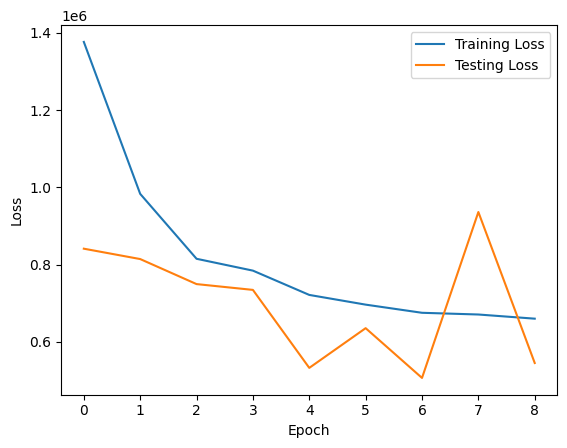

In [ ]:
input_size = mask*2 if mask else 2048

# Define the model architecture

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(input_size, activation='relu', input_shape=(input_size,)),
    tf.keras.layers.Dense(input_size, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
model.compile(optimizer = optimizer, loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Get the training and testing loss from the history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

clear_output(wait = True)

# Plot the training and testing loss
plt.plot(train_loss[1:], label='Training Loss')
plt.plot(val_loss[1:], label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model evaluating:

In [ ]:
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

train_result = result(train_predictions, y_train)
test_result = result(test_predictions, y_test)

clear_output(wait = True)

result_table(train_result, test_result)

|       |     MPE |     < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|---------:|--------:|--------:|--------:|--------:|--------:|
| Train | 92.0723 |  9.94186 | 42.9319 | 63.7265 | 72.183  | 79.2456 | 83.4164 |
| Test  | 91.5895 | 10.074   | 42.8604 | 63.3797 | 72.2683 | 79.4677 | 83.5955 |


In [ ]:
np.subtract(train_predictions,y_train)

### Ensemble

In [ ]:
input_size = mask * 2 if mask else 2048

def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(input_size, activation='relu', input_shape=(input_size,)),
        tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model

num_models = 5
test_predictions = 0
train_predictions = 0

for i in range(num_models):
    model = create_model()
    clear_output(wait=True)
    print(f"{i+1}/{num_models}:")
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
    test_predictions += model.predict(X_test) / num_models
    train_predictions += model.predict(X_train) / num_models
    del model

train_result = result(train_predictions, y_train)
test_result = result(test_predictions, y_test)

clear_output(wait=True)

result_table(train_result, test_result)

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 4.19256 | 15.9583 | 67.5104 | 93.7812 | 98.7292 | 99.8594 |     100 |
| Test  | 4.40353 | 14.1458 | 64.6875 | 93.1042 | 98.3958 | 99.9167 |     100 |


### Results so far:

Smart Padding, 200 epochs: <br/>

|       |     MPE |     <1% |     <5% |    <10% |    <15% |    <25% |    <50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 25.7584 | 12.2178 | 48.6192 | 68.9547 | 77.4213 | 84.1134 | 89.5724 |
| __Test__  | 14.8679 | 12.262  | 47.4638 | 68.3736 | 76.9246 | 83.9688 | 89.4579 |

<br/>

Smart Padding, 200 epochs, bigger network:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train | 120.766 | 11.4886 | 46.8932 | 65.0569 | 71.7902 | 78.1008 | 85.258  |
| Test  | 123.509 | 11.5304 | 46.5384 | 64.6723 | 71.5421 | 77.9807 | 85.0831 |

<br/>

Smart Padding, 200 epochs, 3 layers:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| __Train__ | 26.3697 | 11.1688 | 46.1676 | 65.0812 | 73.8166 | 81.8968 | 90.6492 |
| __Test__  | 18.4464 | 10.8328 | 45.4484 | 64.6819 | 73.8046 | 81.9582 | 90.3735 |

<br/>

Smart Padding, 200 epochs + Dropout:

|       |    MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|-------:|--------:|--------:|--------:|--------:|--------:|--------:|
| __Train__ | 73.409 | 11.0937 | 47.4976 | 67.6914 | 75.0763 | 80.7922 | 85.3137 |
| __Test__  | 74.665 | 10.7117 | 46.4028 | 66.8863 | 74.6815 | 80.5194 | 85.2042 |

<br/>

XGBoost:


|       |     MPE |     < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|---------:|--------:|--------:|--------:|--------:|--------:|
| Train | 184.78  | 17.7204  | 54.7602 | 68.2958 | 74.0879 | 79.3847 | 83.7548 |
| Test  | 201.701 |  5.99777 | 29.2428 | 50.5305 | 63.9407 | 75.9459 | 83.2372 |

<br/>

Smart Padding, 100 epochs: <br/>

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 92.1065 | 10.4046 | 44.7953 | 65.7461 | 75.2095 | 83.6979 | 88.8687 |
| __Test__  | 91.3669 | 10.4162 | 43.995  | 65.4716 | 75.2386 | 83.7217 | 88.673  |

<br/>

Naive Padding, 200 epochs: <br/>

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 32.7174 | 11.3566 | 47.7895 | 66.8811 | 74.8922 | 82.3014 | 90.1865 |
| __Test__  | 34.5956 | 10.0237 | 43.1762 | 64.3041 | 73.8385 | 81.9534 | 90.3105 |

 <br/>

 Smart Padding, 100 epochs + min-max cost normalization: <br/>


|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 89909.8    | 1.15916 | 6.4983  | 14.5155 | 23.062  | 47.2008 | 81.4111 |
| __Test__  |    36.5154 | 1.21603 | 6.36113 | 14.6117 | 23.3225 | 47.8611 | 81.779  |

<br/>

Smart Padding, 100 epochs, leaky-relu:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 579.321 | 8.86265 | 39.1    | 57.8101 | 65.6529 | 72.8173 | 79.2454 |
| __Test__  | 593.362 | 8.38622 | 37.9197 | 56.9546 | 64.9532 | 72.4723 | 79.25   |

<br/>

Smart Padding, 100 epochs, regularization:

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 57.2114 | 11.64   | 48.9789 | 70.0363 |  78.251 | 84.4998 | 88.8154 |
| __Test__  | 57.8539 | 11.7678 | 48.0839 | 69.2457 |  78.252 | 84.4678 | 88.673  |

<br/>

Mean result when training by num of Antennas (Ensembling):

|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|-------|---------|---------|---------|---------|---------|---------|---------|
| __Train__ | 9.6208 | 10.6597   | 45.3978 | 68.3191 |  80.8 | 92.009 | 97.7979 |
| __Test__  | 10.427 | 11.7678 | 48.0839 | 69.2457 |  79.515 | 90.7656 | 97.3643  |

<br/>

Mean of 5 ANN (Ensembling):


|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| __Train__ | 33.6106 | 11.2016 | 46.5746 | 67.0531 | 75.6589 | 82.8694 | 92.2541 |
| __Test__  | 29.6975 | 11.4093 | 46.1557 | 66.7555 | 75.6649 | 83.1307 | 92.4132 |

In [ ]:
### -- This section take from some reason over the system RAM so I used loops -- ###

# Make predictions on training and testing data
#train_predictions = model.predict(X_train)
#test_predictions = model.predict(X_test)

# Calculate percentage errors
#train_percentage_errors = np.abs((train_predictions - y_train) / y_train) * 100
#test_percentage_errors = np.abs((test_predictions - y_test) / y_test) * 100

#train_result = ['Train',np.mean(train_percentage_errors)]
#test_result = ['Test',np.mean(test_percentage_errors)]

#for i in [1,5,10,15,25,50]:
#  train_result.append(100 * np.sum(train_percentage_errors <= i)/len(train_percentage_errors))
#  test_result.append(100 * np.sum(test_percentage_errors <= i)/len(test_percentage_errors))

#clear_output(wait = True)

#print(tabulate([train_result, test_result], headers=['MPE', '< 1%','< 5%','< 10%','< 15%','< 25%','< 50%'], tablefmt='orgtbl'))


### Result per mask



|       |     MPE |    < 1% |    < 5% |   < 10% |   < 15% |   < 25% |   < 50% |
|:------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| Train 800 | 3.16809 | 20.7143 | 79.5536 | 98.2887 | 99.8363 |     100 |     100 |
| Test 800 | 3.4475  | 19.0476 | 76.0714 | 96.9643 | 99.8214 |     100 |     100 |
| Train 804 | 3.76413 | 17.5208 | 71.3802 | 96.5365 | 99.5885 |  99.974 |     100 |
| Test  804 | 4.16011 | 15.5208 | 66.6458 | 94.5833 | 99.3333 | 100     |     100 |
| Train 808 | 5.18512 | 13.1771 | 59.2448 | 86.9271 | 96.2413 | 99.5833 | 100     |
| Test  808 | 5.76491 | 12.6389 | 54.1667 | 84.0278 | 95.3125 | 98.9931 |  99.9653|
| Train 812 | 6.63829 | 13.0398 | 50.7008 | 75.0568 | 90.2083 | 99.1572 | 99.9811 |
| Test 812 | 7.25406 | 10.6818 | 46.2121 | 72.0076 | 88.4848 | 98.8258 | 99.9621 |
| Train 816 | 13.5061 | 4.0625 | 21.4375 |  43.125 | 62.1667 | 89.25   | 99.0833 |
| Test  816 | 14.1243 | 4.75   | 22.0833 |  42     | 61.25   | 86.3333 | 98.5    |
| Train 820 | 12.5581 | 4.72222 | 23.9583 | 45.9028 | 65.4514 | 91.0069 | 99.3056 |
| Test 820 | 14.0699 | 4.58333 | 20.8333 | 41.6667 | 61.8056 | 86.8056 | 98.6111 |
| Train 824 |  9.39521 |  6.45833 | 37.9167 | 66.1458 | 82.3958 |   93.75 | 99.4792 |
| Test  824 | 10.813   | 10       | 31.6667 | 55      | 75.4167 |   92.5  | 99.1667 |
| Train 828 | 11.3521 | 6.04167 | 28.3333 | 51.9271 | 71.875  | 93.0729 | 99.2187 |
| Test  828 | 12.2213 | 6.66667 | 27.2917 | 50.8333 | 70.2083 | 91.0417 | 98.5417 |
| Train 832 | 15.7026 | 3.99306 | 18.1597 | 36.25   | 53.75   | 82.9167 | 98.4028 |
| Test  832 | 16.6186 | 2.91667 | 18.3333 | 35.9722 | 51.9444 | 80.4167 | 96.9444 |
| Train 836 | 14.0333 | 4.53125 | 22.8646 |   41.25 | 56.0938 | 85.2083 | 99.7396 |
| Test 836 | 13.7394 | 4.375   | 23.9583 |   43.75 | 61.4583 | 84.1667 | 99.5833 |
| Train 840 | 15.5021 | 4.0625  | 16.9792 | 34.7396 | 54.4792 | 84.5312 | 98.3854 |
| Test  840 | 16.1836 | 3.54167 | 14.7917 | 32.7083 | 54.5833 | 81.6667 | 98.3333 |
| Train 844 | 8.32749 | 7.39583 | 37.1875 | 70.2083 | 88.125  | 96.25   | 99.7917 |
| Test  844 | 9.36509 | 8.33333 | 37.5    | 64.1667 | 83.3333 | 94.5833 | 99.5833 |
| Train 848 | 30.3286 | 2.22222 | 11.7708  | 21.3542 | 30.3819 | 49.6181 | 79.375  |
| Test  848 | 33.1082 | 1.52778 |  9.58333 | 19.3056 | 27.6389 | 43.75   | 77.0833 |
| Train 852 | 41.1571 | 1.18056  | 7.63889 | 4.6875 | 22.13611 | 38.8889 | 67.6389 |
| Test  852 | 45.329  | 0.555556 | 6.80556 | 13.4722 | 19.1667 | 35.2778 | 63.1944 |
| Train 856 | 23.1981 | 2.91667 | 15.5729 | 30      | 42.5521 | 56.4063 | 93.6458 |
| Test 856 | 24.9426 | 2.91667 | 15.8333 | 26.6667 | 38.5417 | 52.7083 | 91.25   |
| Train 860 | 14.7276 | 5.24306 | 22.5347 | 32.2917 | 43.4028 | 90.3472 |     100 |
| Test 860 | 15.4025 | 5.55556 | 20.5556 | 30.6944 | 39.5833 | 88.3333 |     100 |
| Train 864 | 7.27732 | 1.97917 | 24.0625 | 80.7292 | 97.9167 |     100 |     100 |
| Test 864 | 7.08203 | 3.75    | 29.5833 | 82.0833 | 97.9167 |     100 |     100 |
| Train 868 | 12.3138 | 1.40625 | 10.6771  | 38.9063 | 68.1771 | 97.2917 |     100 |
| Test 868 | 13.703  | 1.04167 |  6.04167 | 31.25   | 61.4583 | 94.5833 |     100 |
| Train 872 | 2.55732 | 25.625  | 88.2292 | 99.7917 |     100 |     100 |     100 |
| Test 872 | 3.20567 | 20.8333 | 79.5833 | 99.5833 |     100 |     100 |     100 |
| Train 884 | 1.81053 | 33.0208 | 97.6042 |     100 |     100 |     100 |     100 |
| Test 884 | 2.36466 | 24.5833 | 90.8333 |     100 |     100 |     100 |     100 |
| Train 888 | 1.57759 | 37.9167 | 98.75   |     100 |     100 |     100 |     100 |
| Test  888 | 1.80996 | 30      | 96.6667 |     100 |     100 |     100 |     100 |
| Train 1024 | 0 | 100 | 100 |     100 |     100 |     100 |     100 |
| Test  1024 | 0 | 100 | 100 |     100 |     100 |     100 |     100 |
